## ResNet

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.
219055592/219055592 [==============================] - 6s 0us/step
Epoch 1/20
384/384 [==============================] - 8535s 22s/step - loss: 2.7088 - accuracy: 0.5773 - val_loss: 1.2124 - val_accuracy: 0.6939 - lr: 9.5000e-04
Epoch 2/20
384/384 [==============================] - 110s 285ms/step - loss: 0.9892 - accuracy: 0.7094 - val_loss: 0.8996 - val_accuracy: 0.7252 - lr: 9.0250e-04
Epoch 3/20
384/384 [==============================] - 113s 294ms/step - loss: 0.7851 - accuracy: 0.7508 - val_loss: 0.7102 - val_accuracy: 0.7875 - lr: 8.5737e-04
Epoch 4/20
384/384 [==============================] - 108s 281ms/step - loss: 0.7214 - accuracy: 0.7716 - val_loss: 0.7415 - val_accuracy: 0.7777 - lr: 8.1451e-04
Epoch 5/20
384/384 [==============================] - 117s 305ms/step - loss: 0.6536 - accuracy: 0.7927 - val_loss: 0.6289 - val_accuracy: 0.8100 - lr: 7.7378e-04
Epoch 6/20
384/384 [==============

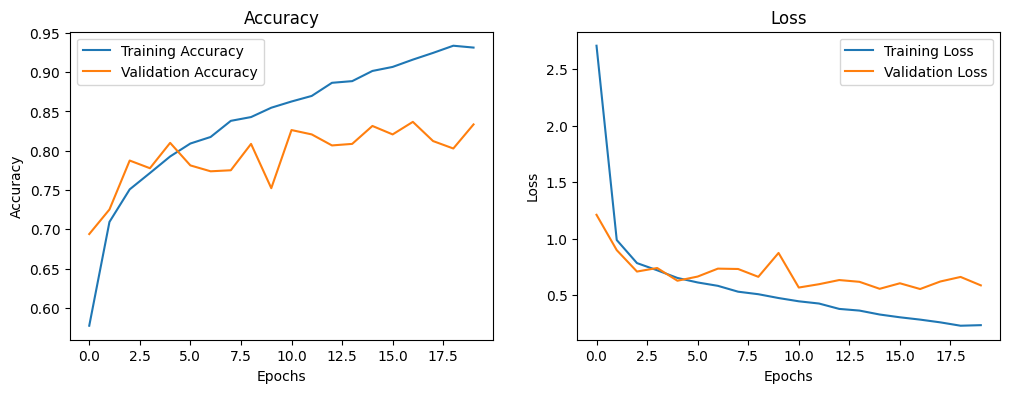

48/96 [==============>...............] - ETA: 6s

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionResNetV2
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

number_of_classes = 7

# Chemins des répertoires de données d'entraînement et de test
train_data_dir = r"/content/drive/MyDrive/Fil_rouge/Dataset/archive(3)/DATASET/train"
test_data_dir = r"/content/drive/MyDrive/Fil_rouge/Dataset/archive(3)/DATASET/test"

#train_data_dir = r"/home/alammar/Téléchargements/archive(3)/DATASET/train"
#test_data_dir = r"/home/alammar/Téléchargements/archive(3)/DATASET/test"

# Prétraitement des données d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Redimensionner les valeurs des pixels à [0, 1]
    rotation_range=15,       # Rotation aléatoire des images de 15 degrés
    width_shift_range=0.1,   # Décalage horizontal aléatoire jusqu'à 10%
    height_shift_range=0.1,  # Décalage vertical aléatoire jusqu'à 10%
    shear_range=0.1,         # Cisaillement aléatoire jusqu'à 10%
    zoom_range=0.1,          # Zoom aléatoire jusqu'à 10%
    horizontal_flip=True,    # Flip horizontal aléatoire
    fill_mode='nearest'      # Remplir les pixels vides avec la valeur du pixel le plus proche
)

# Prétraitement des données de test
test_datagen = ImageDataGenerator(rescale=1./255)  # Redimensionner les valeurs des pixels à [0, 1]

# Générateur de données d'entraînement
train_generator = train_datagen.flow_from_directory(
    train_data_dir,         # Répertoire contenant les images d'entraînement
    target_size=(100, 100), # Redimensionner toutes les images à 100x100 pixels
    batch_size=32,          # Traiter les images par lots de 32
    class_mode='categorical'# Les étiquettes des classes sont codées de manière catégorielle
)

# Générateur de données de test
test_generator = test_datagen.flow_from_directory(
    test_data_dir,          # Répertoire contenant les images de test
    target_size=(100, 100), # Redimensionner toutes les images à 100x100 pixels
    batch_size=32,          # Traiter les images par lots de 32
    class_mode='categorical', # Les étiquettes des classes sont codées de manière catégorielle
    shuffle=False           # Ne pas mélanger les images lors de la génération de lots
)

# Chargement du modèle de base InceptionResNetV2 pré-entraîné
base_model = InceptionResNetV2(include_top=False, input_shape=(100, 100, 3))

# Construction du modèle séquentiel
model = Sequential()
model.add(base_model)                  # Ajouter le modèle de base
model.add(GlobalAveragePooling2D())    # Appliquer un pool moyen global 2D
model.add(Dropout(0.5))                # Appliquer un dropout de 50% pour régularisation
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Couche dense avec régularisation L2
model.add(Dense(number_of_classes, activation='softmax'))  # Couche de sortie pour classification

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Geler les couches du modèle de base sauf les 10 dernières
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Définition du scheduler d'apprentissage
def lr_scheduler(epoch, lr):
    return lr * 0.95

# Callback pour ajuster le taux d'apprentissage
lr_callback = LearningRateScheduler(lr_scheduler)

# Entraînement du modèle
history = model.fit(
    train_generator,                  # Générateur de données d'entraînement
    steps_per_epoch=len(train_generator),  # Nombre de pas par époque
    epochs=20,                        # Nombre d'époques d'entraînement
    validation_data=test_generator,    # Générateur de données de validation
    validation_steps=len(test_generator), # Nombre de pas de validation
    callbacks=[lr_callback]            # Utiliser le callback pour ajuster le taux d'apprentissage
)

# Tracer les courbes de précision et de perte
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Prédictions sur les données de test
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Générer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
cmd.plot(cmap=plt.cm.Blues)
plt.show()


Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
384/384 [==============================] - 5008s 13s/step - loss: 2.6271 - accuracy: 0.5753 - val_loss: 3.8579 - val_accuracy: 0.4560 - lr: 9.5000e-04
Epoch 2/20
384/384 [==============================] - 571s 1s/step - loss: 1.0107 - accuracy: 0.6920 - val_loss: 3.9565 - val_accuracy: 0.4674 - lr: 9.0250e-04
Epoch 3/20
384/384 [==============================] - 577s 2s/step - loss: 0.8539 - accuracy: 0.7250 - val_loss: 4.3035 - val_accuracy: 0.4707 - lr: 8.5737e-04
Epoch 4/20
384/384 [==============================] - 581s 2s/step - loss: 0.7781 - accuracy: 0.7511 - val_loss: 2.6649 - val_accuracy: 0.5306 - lr: 8.1451e-04
Epoch 5/20
384/384 [==============================] - 585s 2s/step - loss: 0.7291 - accuracy: 0.7680 - val_loss: 3.1292 - val_accuracy: 0.5593 - lr: 7.7378e-04
Epoch 6/20
384/384 [==============================] - 572s 1s/step - loss: 0.6873 - accuracy: 0.7801 - val_loss: 2.1157 - val_accuracy:

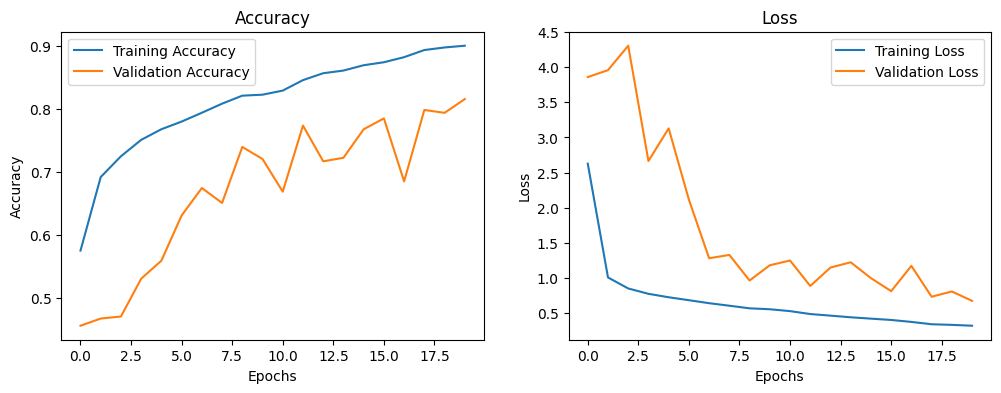

96/96 [==============================] - 32s 315ms/step


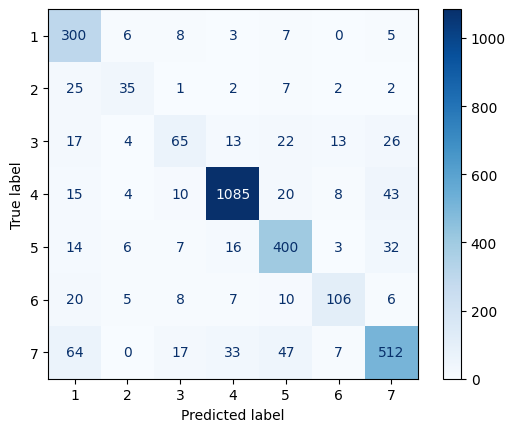

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

number_of_classes = 7

# Chemins des répertoires de données d'entraînement et de test
train_data_dir = r"/content/drive/MyDrive/Fil_rouge/Dataset/archive(3)/DATASET/train"
test_data_dir = r"/content/drive/MyDrive/Fil_rouge/Dataset/archive(3)/DATASET/test"

#train_data_dir = r"/home/alammar/Téléchargements/archive(3)/DATASET/train"
#test_data_dir = r"/home/alammar/Téléchargements/archive(3)/DATASET/test"

# Prétraitement des données d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Redimensionner les valeurs des pixels à [0, 1]
    rotation_range=15,       # Rotation aléatoire des images de 15 degrés
    width_shift_range=0.1,   # Décalage horizontal aléatoire jusqu'à 10%
    height_shift_range=0.1,  # Décalage vertical aléatoire jusqu'à 10%
    shear_range=0.1,         # Cisaillement aléatoire jusqu'à 10%
    zoom_range=0.1,          # Zoom aléatoire jusqu'à 10%
    horizontal_flip=True,    # Flip horizontal aléatoire
    fill_mode='nearest'      # Remplir les pixels vides avec la valeur du pixel le plus proche
)

# Prétraitement des données de test
test_datagen = ImageDataGenerator(rescale=1./255)  # Redimensionner les valeurs des pixels à [0, 1]

# Générateur de données d'entraînement
train_generator = train_datagen.flow_from_directory(
    train_data_dir,         # Répertoire contenant les images d'entraînement
    target_size=(100, 100), # Redimensionner toutes les images à 100x100 pixels
    batch_size=32,          # Traiter les images par lots de 32
    class_mode='categorical'# Les étiquettes des classes sont codées de manière catégorielle
)

# Générateur de données de test
test_generator = test_datagen.flow_from_directory(
    test_data_dir,          # Répertoire contenant les images de test
    target_size=(100, 100), # Redimensionner toutes les images à 100x100 pixels
    batch_size=32,          # Traiter les images par lots de 32
    class_mode='categorical', # Les étiquettes des classes sont codées de manière catégorielle
    shuffle=False           # Ne pas mélanger les images lors de la génération de lots
)

# Chargement du modèle de base MobileNetV2 pré-entraîné
base_model = MobileNetV2(include_top=False, input_shape=(100, 100, 3))

# Construction du modèle séquentiel
model = Sequential()
model.add(base_model)                  # Ajouter le modèle de base
model.add(GlobalAveragePooling2D())    # Appliquer un pool moyen global 2D
model.add(Dropout(0.5))                # Appliquer un dropout de 50% pour régularisation
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Couche dense avec régularisation L2
model.add(Dense(number_of_classes, activation='softmax'))  # Couche de sortie pour classification

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Geler les couches du modèle de base sauf les 10 dernières
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Définition du scheduler d'apprentissage
def lr_scheduler(epoch, lr):
    return lr * 0.95

# Callback pour ajuster le taux d'apprentissage
lr_callback = LearningRateScheduler(lr_scheduler)

# Entraînement du modèle
history = model.fit(
    train_generator,                  # Générateur de données d'entraînement
    steps_per_epoch=len(train_generator),  # Nombre de pas par époque
    epochs=20,                        # Nombre d'époques d'entraînement
    validation_data=test_generator,    # Générateur de données de validation
    validation_steps=len(test_generator), # Nombre de pas de validation
    callbacks=[lr_callback]            # Utiliser le callback pour ajuster le taux d'apprentissage
)

# Tracer les courbes de précision et de perte
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Prédictions sur les données de test
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Générer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
cmd.plot(cmap=plt.cm.Blues)
plt.show()
